In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'

In [2]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import anneal_dsm_score_estimation
from tools.score_net import score_model_cond
from tools.sampling import annealed_langevin_dynamic_sampler

In [3]:
import sbibm
from sbibm.metrics import mmd

task = sbibm.get_task("two_moons")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
simulator = task.get_simulator()

# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
thetas = prior(num_samples=10000)
samples = simulator(thetas)

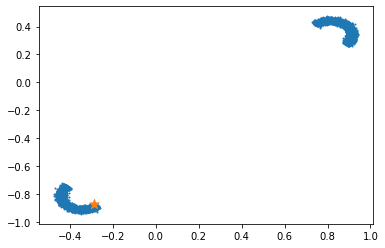

In [4]:
import os

obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_2/'

obs=np.loadtxt(os.path.join(obs_loc,'observation.csv'),delimiter=',',skiprows=1)

true_theta=np.loadtxt(os.path.join(obs_loc,'true_parameters.csv'),delimiter=',',skiprows=1)

ref_posterior=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)

plt.scatter(ref_posterior[:,0],ref_posterior[:,1],s=1)

plt.scatter(true_theta[0],true_theta[1],marker='*',s=100)

In [11]:
ns=noise_scheduler(1e-5,1e-1,100,schedule='sigmoid',var_norm=False)


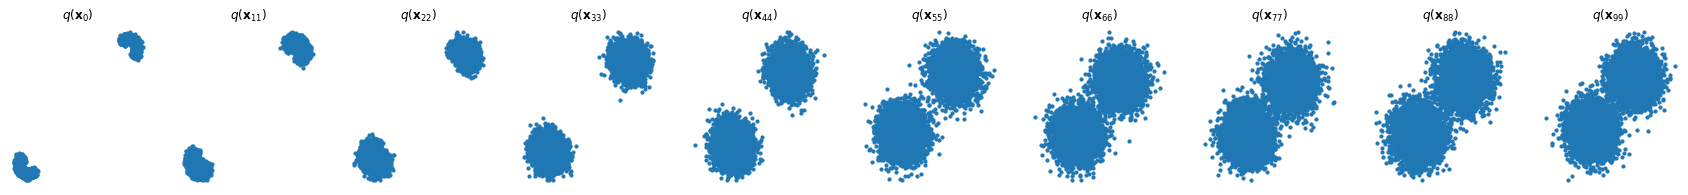

In [12]:
ns.visualize_noise(torch.tensor(ref_posterior))

In [13]:
model = score_model_cond(100,x_dim=2,x_cond_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [14]:
epochs=1000
# batch = (torch.tensor(samples, dtype=torch.float32).to(device),torch.tensor(thetas, dtype=torch.float32).to(device)
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)
batch_size=128
for epoch in range(epochs):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = thetas[indices]
        batch_x_cond = dataset[indices]

        labels = torch.randint(0, ns.n_steps, (batch_x.shape[0],)).to(device)

        loss = anneal_dsm_score_estimation(model, batch_x, labels, ns,samples_cond=batch_x_cond)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if ((epoch % 100) == 0):
        print(loss.item())

/tmp/ipykernel_2986717/3741256553.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset=torch.tensor(samples).float().to(device)
/tmp/ipykernel_2986717/3741256553.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)


1.3067365884780884
0.42964115738868713
0.40593042969703674
0.22959396243095398
0.13602831959724426
0.10056764632463455
0.24711480736732483
0.145472452044487
0.3160831928253174
0.38639602065086365


(-1.0, 1.0)

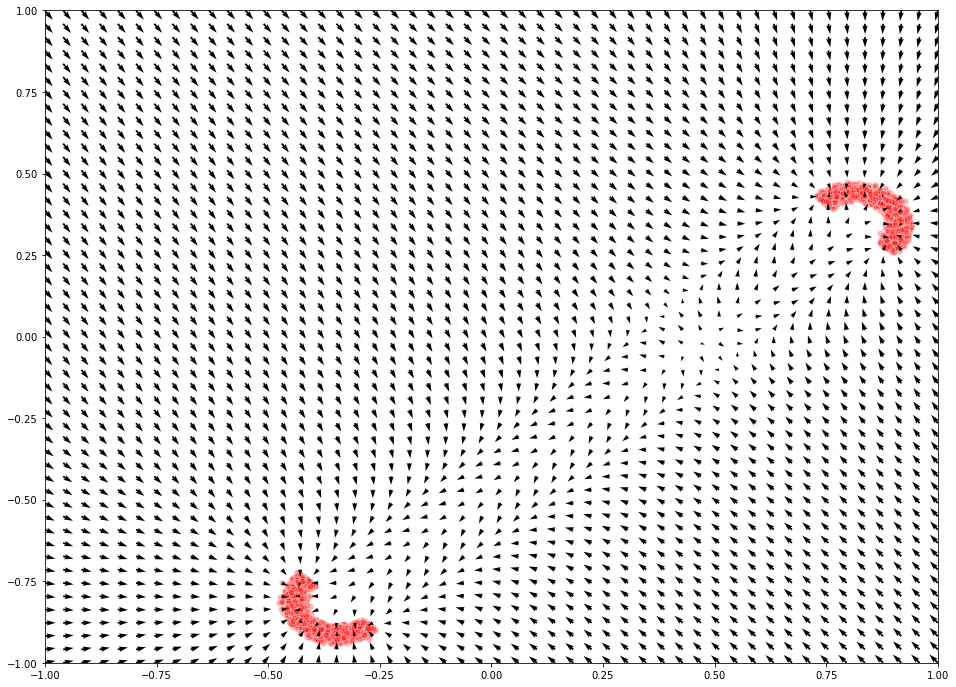

In [15]:
xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)), axis=-1).reshape(-1, 2)
# xx = np.stack(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)), axis=-1).reshape(-1, 2)
labels = torch.ones(xx.shape[0]).long().to(device)*0
sample_cond = torch.tensor(np.repeat(obs[None,:],xx.shape[0],axis=0),dtype=torch.float32).to(device)

scores = model(torch.tensor(xx).float().to(device),sample_cond, labels).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*ref_posterior.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [16]:
sampler = annealed_langevin_dynamic_sampler(sigmas=ns.sigmas, 
                                            n_iter_each_T=1000 , 
                                            score_fn=model, 
                                            device=device, 
                                            eps = 1e-5)

In [17]:
init_point=torch.randn(10000,2).to(device)*3.5-1.5

sample_cond=torch.tensor(np.repeat(obs[None,:],10000,axis=0),dtype=torch.float32).to(device)

dynamic=sampler.sample(init_point,sample_cond=sample_cond)

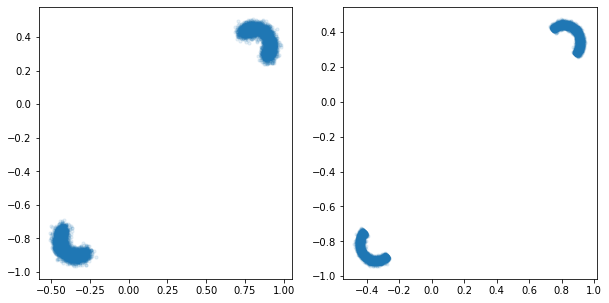

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(*dynamic[-1].cpu().numpy().T , s=10, alpha=0.1)

plt.subplot(1, 2, 2)
plt.scatter(*ref_posterior.T, s=10, alpha=0.1)

